In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier,\
GradientBoostingRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## Data 1 : predicting visibility

In [182]:
train = pd.read_csv('train1.csv')
test = pd.read_table('test1.txt',sep=',')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [183]:
test[test.isnull()].shape

(10000, 9)

In [184]:
test.Summary.unique()

array(['Mostly Cloudy', 'Partly Cloudy', 'Overcast', 'Clear',
       'Breezy and Partly Cloudy', 'Breezy and Mostly Cloudy',
       'Breezy and Overcast', 'Foggy', 'Dry and Partly Cloudy',
       'Light Rain', 'Drizzle', 'Windy and Dry', 'Dry', 'Breezy',
       'Dry and Mostly Cloudy', 'Breezy and Foggy',
       'Windy and Partly Cloudy', 'Humid and Overcast',
       'Humid and Mostly Cloudy', 'Windy and Mostly Cloudy',
       'Breezy and Dry', 'Windy and Overcast'], dtype=object)

In [185]:
train.Summary.unique()

array(['Partly Cloudy', 'Mostly Cloudy', 'Overcast', 'Foggy',
       'Breezy and Mostly Cloudy', 'Clear', 'Breezy and Partly Cloudy',
       'Breezy and Overcast', 'Humid and Mostly Cloudy',
       'Humid and Partly Cloudy', 'Windy and Foggy', 'Windy and Overcast',
       'Breezy and Foggy', 'Windy and Partly Cloudy', 'Breezy',
       'Dry and Partly Cloudy', 'Windy and Mostly Cloudy',
       'Dangerously Windy and Partly Cloudy', 'Dry', 'Windy',
       'Humid and Overcast'], dtype=object)

In [186]:
test.rename(columns={'Wind Speed (kmh)':'Wind Speed (km/h)'},inplace=True)

In [187]:
test.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Pressure (millibars)
0,2011-05-21 190000.000 +0200,Mostly Cloudy,rain,23.750000,23.750000,0.50,7.7441,342,1017.51
1,2011-05-21 200000.000 +0200,Mostly Cloudy,rain,22.188889,22.188889,0.59,8.1305,338,1017.59
2,2011-05-21 210000.000 +0200,Mostly Cloudy,rain,18.888889,18.888889,0.83,10.5777,201,1018.44
3,2011-05-21 220000.000 +0200,Mostly Cloudy,rain,18.866667,18.866667,0.80,3.1556,242,1019.00
4,2011-05-21 230000.000 +0200,Mostly Cloudy,rain,18.344444,18.344444,0.80,10.5777,286,1018.66


In [188]:
train.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Pressure (millibars),Visibility
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,1015.13,15.8263
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,1015.63,15.8263
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,1015.94,14.9569
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,1016.41,15.8263
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,1016.51,15.8263


In [189]:
# 시간을 : 월 / 일 / 시간 컬럼으로 나누어 분류하는 것이 필요할 듯 + 계절적 요소?

### Remove Outlier

In [190]:
train.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Pressure (millibars)', 'Visibility'],
      dtype='object')

In [191]:
numerical_list = ['Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Pressure (millibars)']

In [192]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from age, balance, duration
outliers_to_drop = detect_outliers(train, 1, numerical_list)

In [193]:
len(outliers_to_drop)

162

In [194]:
# Drop outliers
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True)

In [195]:
# joining train & test set
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [196]:
dataset.head()

,Apparent Temperature (C),Formatted Date,Humidity,Precip Type,Pressure (millibars),Summary,Temperature (C),Visibility,Wind Bearing (degrees),Wind Speed (km/h)
0,7.388889,2006-04-01 00:00:00.000 +0200,0.89,rain,1015.13,Partly Cloudy,9.472222,15.8263,251,14.1197
1,7.227778,2006-04-01 01:00:00.000 +0200,0.86,rain,1015.63,Partly Cloudy,9.355556,15.8263,259,14.2646
2,9.377778,2006-04-01 02:00:00.000 +0200,0.89,rain,1015.94,Mostly Cloudy,9.377778,14.9569,204,3.9284
3,5.944444,2006-04-01 03:00:00.000 +0200,0.83,rain,1016.41,Partly Cloudy,8.288889,15.8263,269,14.1036
4,6.977778,2006-04-01 04:00:00.000 +0200,0.83,rain,1016.51,Mostly Cloudy,8.755556,15.8263,259,11.0446


In [197]:
dataset.isnull().sum()

Apparent Temperature (C)        0
Formatted Date                  0
Humidity                        0
Precip Type                   143
Pressure (millibars)            0
Summary                         0
Temperature (C)                 0
Visibility                  10000
Wind Bearing (degrees)          0
Wind Speed (km/h)               0
dtype: int64

In [198]:
train.isnull().sum()

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Pressure (millibars)        0
Visibility                  0
dtype: int64

In [199]:
test.isnull().sum()

Formatted Date                0
Summary                       0
Precip Type                 143
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Pressure (millibars)          0
dtype: int64

In [200]:
test['Precip Type'].value_counts()

rain    8254
snow    1603
Name: Precip Type, dtype: int64

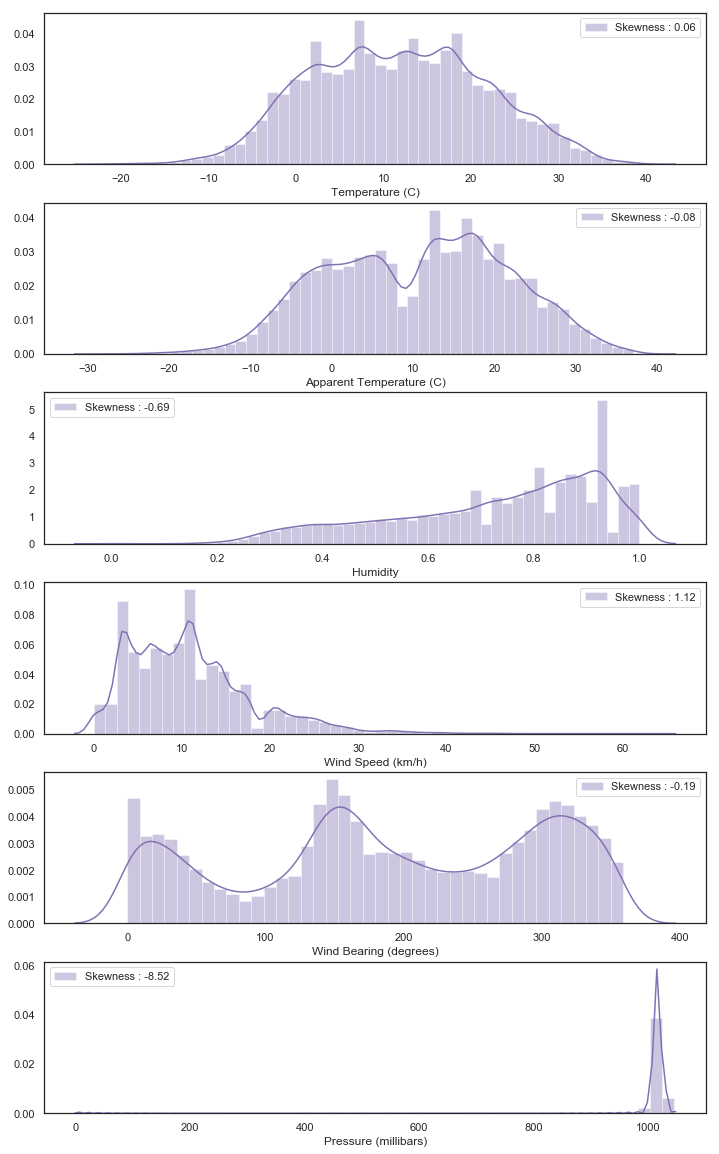

In [201]:
# check distribution of each feature
f, ax = plt.subplots(len(numerical_list),1,figsize=(10,16))
f.tight_layout()
for i, cl in enumerate(numerical_list):
    g = sns.distplot(dataset[cl], color="m", label="Skewness : %.2f"%(dataset[cl].skew()), ax=ax[i])
    g = g.legend(loc="best")

In [202]:
skewedlist = ['Pressure (millibars)']
for cl in skewedlist:
    dataset[cl] = dataset[cl].map(lambda x : np.log(x) if x>0 else x)
    dataset[cl] = dataset[cl].map(lambda x : -np.log(-x) if x<0 else x)

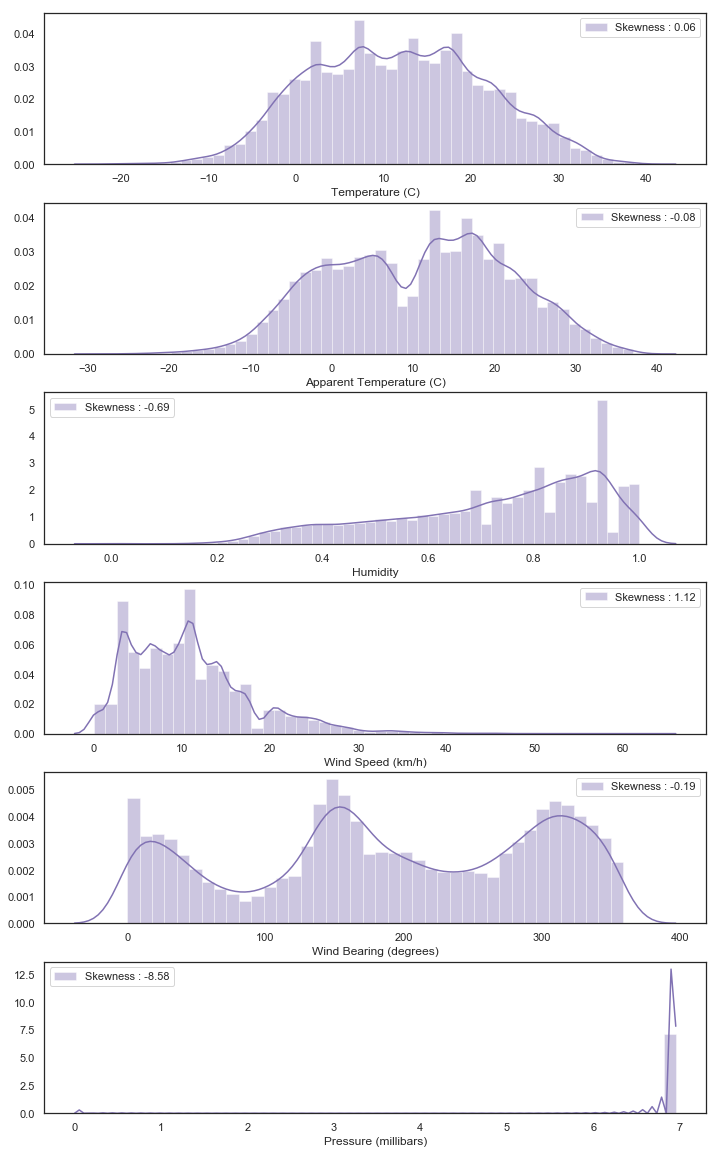

In [203]:
# check distribution of each feature
f, ax = plt.subplots(len(numerical_list),1,figsize=(10,16))
f.tight_layout()
for i, cl in enumerate(numerical_list):
    g = sns.distplot(dataset[cl], color="m", label="Skewness : %.2f"%(dataset[cl].skew()), ax=ax[i])
    g = g.legend(loc="best")

In [204]:
dataset.columns

Index(['Apparent Temperature (C)', 'Formatted Date', 'Humidity', 'Precip Type',
       'Pressure (millibars)', 'Summary', 'Temperature (C)', 'Visibility',
       'Wind Bearing (degrees)', 'Wind Speed (km/h)'],
      dtype='object')

In [205]:
cate_list = ['Precip Type', 'Summary']

In [206]:
# make categorical data as categorical
for cl in cate_list:
    dataset[cl] = dataset[cl].astype('category')

In [207]:
dataset['Precip Type'] = dataset['Precip Type'].fillna('rain')

In [208]:
dataset['Precip Type'].value_counts()

rain    51974
snow     7864
Name: Precip Type, dtype: int64

In [209]:
dataset['month'] = dataset['Formatted Date'].str[5:7]
dataset['day'] = dataset['Formatted Date'].str[8:10]
dataset['hour'] = dataset['Formatted Date'].str[11:13]

In [210]:
dataset.drop(columns='Formatted Date', inplace=True)

In [211]:
dataset = pd.get_dummies(dataset)

In [212]:
dataset.fillna(0, inplace=True)

In [213]:
train_len = len(train)
train = dataset[:train_len]
test = dataset[train_len:].drop(columns='Visibility')

train.corr()['Visibility'].sort_values()

Summary_Foggy                      -0.622537
Precip Type_snow                   -0.356971
Humidity                           -0.331922
month_12                           -0.247022
month_01                           -0.219529
month_02                           -0.120409
month_11                           -0.116872
Summary_Overcast                   -0.106530
hour_06                            -0.104450
hour_07                            -0.103941
hour_08                            -0.085250
hour_09                            -0.064622
hour_10                            -0.042167
hour_20                            -0.036656
hour_19                            -0.033876
hour_18                            -0.029343
Summary_Breezy and Foggy           -0.028905
hour_11                            -0.019009
hour_17                            -0.017229
hour_16                            -0.016947
day_16                             -0.016908
month_10                           -0.016314
day_20    

In [214]:
features = list(train.corr()['Visibility'].sort_values().index[-21:-5]) + \
    list(train.corr()['Visibility'].sort_values().index[:15])

In [215]:
features

['hour_23',
 'hour_00',
 'month_04',
 'month_06',
 'month_05',
 'hour_22',
 'Wind Speed (km/h)',
 'Summary_Clear',
 'month_07',
 'Summary_Mostly Cloudy',
 'month_08',
 'Summary_Partly Cloudy',
 'Precip Type_rain',
 'Apparent Temperature (C)',
 'Temperature (C)',
 'Visibility',
 'Summary_Foggy',
 'Precip Type_snow',
 'Humidity',
 'month_12',
 'month_01',
 'month_02',
 'month_11',
 'Summary_Overcast',
 'hour_06',
 'hour_07',
 'hour_08',
 'hour_09',
 'hour_10',
 'hour_20',
 'hour_19']

In [216]:
train_len = len(train)
train = dataset[features][:train_len]
test = dataset[features][train_len:].drop(columns='Visibility')

In [217]:
# Separate train featrues and label

train['Visibility'] = train['Visibility'].astype('float')

Y_train = train['Visibility']

X_train = train.drop(columns='Visibility')

In [224]:
from sklearn.model_selection import KFold
kfold = KFold()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


In [229]:
GBC = GradientBoostingRegressor()
gb_param_grid = {'loss' : ["ls"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, n_jobs= 4,\
                     verbose = 2)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:  3.9min finished


0.6763380798055507

In [231]:
Y_train.nunique()

859

In [233]:
ans = gsGBC.predict(test)
ans

array([10.38790594, 10.19535679, 12.26620341, ...,  6.25893356,
        8.45177037, 10.0033912 ])

In [238]:
ans = pd.Series(ans, name='Visibility')

In [235]:
test = pd.read_table('test1.txt',sep=',')
f_date = test['Formatted Date']

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [239]:
results = pd.concat([f_date, ans], axis=1)

In [241]:
results.to_csv('1_gbs.csv',index=False)

In [244]:
best_params = GBC_best.get_params

In [247]:
print(GBC_best.get_params)

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=8, max_features=0.3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=100,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)>


In [248]:
GBC_test = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=8, max_features=0.3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=100,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [249]:
GBC_test.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=8, max_features=0.3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=100,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)